In [99]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
import glob
import matplotlib.pyplot as plt

In [41]:
X_signal = np.load('data/signal.npz')['X'][:,:9]
y_signal = np.ones(X_signal.shape[0])

In [32]:
def get_bkg_features(sets_of_npzs, weights, n_target_events=10000):
    """
    Gets a combined, weighted combination of events
    """
    weights /= np.sum(weights) # normalize
    n_events_per_set = (weights * n_target_events).astype(np.int32)

    print(f'n_events per set: {n_events_per_set}')

    X_combined = []
    for n_events, npzs in zip(n_events_per_set, sets_of_npzs):
        n_events_todo = n_events
        for npz in npzs:
            X = np.load(npz)['X'][:,:9]
            n_events_this_npz = X.shape[0]
            if n_events_this_npz > n_events_todo:
                X = X[:n_events_todo]
            X_combined.append(X)
            n_events_todo -= X.shape[0]
            if n_events_todo == 0: break
        else:
            print(f'Warning: reached end of set of files with n_events_todo={n_events_todo}')

    X_final = np.vstack(X_combined)
    assert len(X_final.shape) == 2
    assert X_final.shape[1] == 9
    return X_final

In [36]:
labels = ['300to470', '470to600', '600to800', '800to1000', '1000to1400']
crosssections = [.1*6826.0, 552.6, 156.6, 26.32, 7.50]
sets_of_npzs = [ glob.iglob(f'data/bkg/*{l}*/*.npz') for l in labels ]
X_bkg = get_bkg_features(sets_of_npzs, crosssections)
y_bkg = np.zeros(X_bkg.shape[0])

n_events per set: [4788 3876 1098  184   52]


In [87]:
X = np.vstack((X_signal, X_bkg))
y = np.concatenate((y_signal, y_bkg)).astype(np.int8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
y_train = y_train.astype(np.int8)
y_test = y_test.astype(np.int8)

In [88]:
y_train

array([0, 1, 1, ..., 0, 0, 0], dtype=int8)

In [121]:
model = xgb.XGBClassifier(
    eta=.03, scale_pos_weight=y.shape[0]/np.sum(y),
    max_depth=3,
    n_estimators=850,

    )
model.fit(X_train, y_train)

# NTrees=850
# MinNodeSize=2.5%
# MaxDepth=3
# BoostType=AdaBoost
# AdaBoostBeta=0.5
# UseBaggedBoost
# BaggedSampleFraction=0.5
# SeparationType=GiniIndex
# nCuts=20


/Users/klijnsma/miniconda3/envs/svj-bdt/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.03, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0299999993, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=850, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4.693387513852974,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [122]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
confusion_matrix(y_test, y_pred)

array([[1394,  589],
       [ 116,  442]])

Text(0, 0.5, 'Sig efficiency')

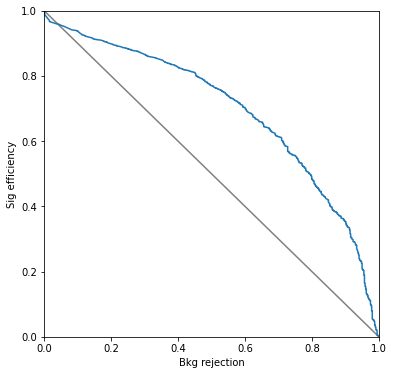

In [123]:
cuts, eff_bkg, eff_sig = roc_curve(y_test, y_prob)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.plot([0,1], [1,0], c='gray')
ax.plot(eff_bkg, eff_sig)
ax.set_ylim(0., 1.)
ax.set_xlim(0., 1.)
ax.set_xlabel('Bkg rejection')
ax.set_ylabel('Sig efficiency')

In [124]:
auc(eff_bkg, eff_sig)

0.6965427290023167

In [127]:
y_prob_sig = y_prob[y_test == 1]
y_prob_bkg = y_prob[y_test == 0]

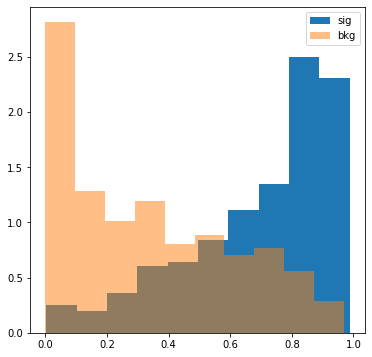

In [131]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca()

ax.hist(y_prob_sig, label='sig', density=True)
ax.hist(y_prob_bkg, label='bkg', alpha=.5, density=True)
ax.legend()

In [137]:
corrmat = np.corrcoef(X.T)

In [138]:
corrmat.shape

(9, 9)

/var/folders/lv/lrgmjwhs3yqd4yv_bqfsmckw0000gp/T/ipykernel_61708/3519977219.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels, rotation=90)
/var/folders/lv/lrgmjwhs3yqd4yv_bqfsmckw0000gp/T/ipykernel_61708/3519977219.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels)


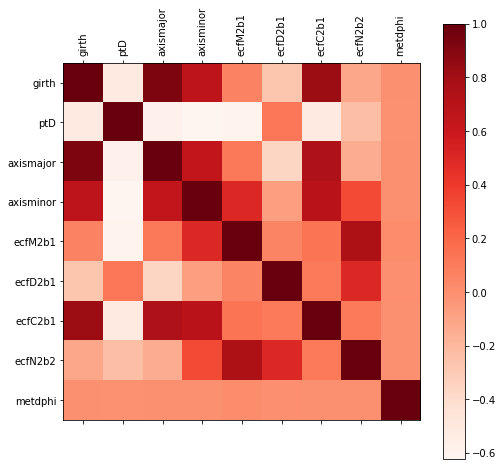

In [158]:
labels = ['girth', 'ptD', 'axismajor', 'axisminor', 'ecfM2b1', 'ecfD2b1', 'ecfC2b1', 'ecfN2b2', 'metdphi']
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
mshow = ax.matshow(corrmat, cmap=plt.cm.Reds)
ax.set_xticklabels(['']+labels, rotation=90)
ax.set_yticklabels(['']+labels)

cbar = fig.colorbar(mshow)
cbar


In [153]:
dir(plt.cm)

['Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'LUTSIZE',
 'MutableMapping',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'ScalarMappable',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 '_DeprecatedCmapDictWrapper',
 '__builtin_cmaps',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__n

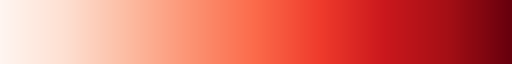

In [154]:
plt.cm.Reds